In [11]:
# fastmri
import fastmri
from fastmri.data import subsample
from fastmri.data import transforms, mri_data
from fastmri.evaluate import ssim, psnr, nmse
from fastmri.losses import SSIMLoss
from fastmri.models import Unet
import logging
import pathlib
import random
import shutil
import time
import os
import sys

import numpy as np
import torch
import torchvision
from tensorboardX import SummaryWriter
from torch.nn import functional as F
from torch.utils.data import DataLoader
from common.args import Args
from data import transforms2
import matplotlib

matplotlib.use('Agg')
import matplotlib.pyplot as plt
from models.subsampling_model import Subsampling_Model
from scipy.spatial import distance_matrix
import scipy.io as sio
from common.utils import get_vel_acc
#from common.evaluate import psnr, ssim
from fastmri.losses import SSIMLoss

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F

import fastmri.models
from models.rec_models.unet_model import UnetModel
from models.rec_models.complex_unet import ComplexUnetModel
import data.transforms2 as transforms
from pytorch_nufft.nufft2 import nufft, nufft_adjoint
import numpy as np
from WaveformProjection.run_projection import proj_handler
import matplotlib.pylab as P
from models.rec_models.vision_transformer import VisionTransformer
from models.rec_models.recon_net import ReconNet
from models.rec_models.humus_net import HUMUSNet, HUMUSBlock
from models.VarBlock import VarNet
from typing import Tuple
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import apply_mask

import torch
import numpy as np

import pathlib
import random
import h5py
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision
import os
import torch

class SliceData(Dataset):
    def __init__(self, root, transform, challenge="multicoil", sample_rate=1, resolution=(320, 320)):
        assert challenge in ["singlecoil", "multicoil"], "Challenge must be 'singlecoil' or 'multicoil'"
        self.transform = transform
        self.challenge = challenge
        self.examples = []

        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]

        for fname in sorted(files):
            try:
                with h5py.File(fname, 'r') as data:
                    if "kspace" not in data:
                        continue  # Skip files without k-space data

                    kspace = data["kspace"]
                    if self.challenge == "multicoil":
                        if len(kspace.shape) != 4:  # Ensure it follows (num_slices, num_coils, height, width)
                            continue
                    else:
                        if len(kspace.shape) != 3:  # Ensure it follows (num_slices, height, width)
                            continue

                    num_slices = kspace.shape[0]
                    temp = [(fname, slice) for slice in range(5, num_slices - 2)]
                    for (fname, slice) in temp:
                        try:
                            with h5py.File(fname, 'r') as data:
                                kspace = data["kspace"][slice]
                                if "reconstruction_rss" in data:
                                    try:
                                        target = data["reconstruction_rss"][slice]
                                        self.transform(kspace, target, data.attrs, fname.name, slice, self.challenge)
                                        self.examples.append((fname, slice))
                                    except Exception as e:
                                        print(e)
                                        continue
                                else:
                                    continue
                        except Exception as e:
                            print(e)
                            continue
                    print(len(self.examples))
            except Exception as e:
                print(e)
                continue

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        fname, slice = self.examples[i]
        try:
            with h5py.File(fname, 'r') as data:
                kspace = data["kspace"][slice]
                if "reconstruction_rss" in data:
                    try:
                        target = data["reconstruction_rss"][slice]
                    except Exception as e:
                        print(e)
                        return None
                else:
                    target = None
                return self.transform(kspace, target, data.attrs, fname.name, slice, self.challenge)
        except Exception as e:
            print(e)
            return None


import torch.nn.functional as F
import torch
from torchvision import transforms as visonTransforms
from PIL import Image
import torch.nn.functional as F

def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

class DataTransform:
    def __init__(self, resolution):
        self.resolution = resolution
        self.resize_transform = visonTransforms.Resize((self.resolution, self.resolution))

    def __call__(self, kspace, target, attrs, fname, slice, challange="multicoil"):
        kspace = transforms.to_tensor(kspace)
        image = transforms.ifft2_regular(kspace)
        # Convert from two channels to complex
        if len(image.shape) == 4:
            image = image.permute(0, 3, 1, 2)
            if image.shape[-2] < self.resolution or image.shape[-1] < self.resolution:
                    image = F.interpolate(image, size=(self.resolution, self.resolution), mode='bilinear', align_corners=False)
            image = image.permute(0, 2, 3, 1)

        image = transforms.complex_center_crop(image, (self.resolution, self.resolution))
        #image, mean, std = transforms.normalize_instance(image, eps=1e-11)

        #print(image.shape)
        target = transforms.to_tensor(target)
        #target, mean, std = transforms.normalize_instance(target, eps=1e-11)
        mean = std = 0

        target = target.unsqueeze(0).unsqueeze(0)
        if target.shape[-2] < self.resolution or target.shape[-1] < self.resolution:
            target = F.interpolate(target, size=(self.resolution, self.resolution), mode='bilinear', align_corners=False)
        target = target.squeeze(0).squeeze(0)

        target = transforms.center_crop(target, (self.resolution, self.resolution))

        return fastmri.rss(image) if challange == "multicoil" else image, normalize(target), mean, std, target, attrs['max']



def create_knee_dataset(data_path, batch_size, sample_rate):
    dev_data = SliceData(
        root="/datasets/4VISTA/fastmri_knee/singlecoil_val",
        challenge="singlecoil",
        transform=DataTransform(320),
        sample_rate=sample_rate)
    return dev_data

def create_m4raw_dataset(data_path, batch_size, sample_rate):
    dev_data = SliceData(
        root=data_path + f'/m4raw/multicoil_val',
        challenge="multicoil",
        transform=DataTransform(320),
        sample_rate=sample_rate)
    return dev_data

def create_datasets(data_path, batch_size, sample_rate, test):
    dev_data = SliceData(
        root=data_path + (f'/multicoil_val' if not test else f'/multicoil_test_full'),
        challenge="multicoil",
        transform=DataTransform(320),
        sample_rate=sample_rate)


    return dev_data

def create_data_loaders(data_path, batch_size, sample_rate, test = False,knee = False, m4raw = False):
    if knee:
        dev_data = create_knee_dataset(data_path, batch_size, sample_rate)
    elif m4raw:
        dev_data = create_m4raw_dataset(data_path, batch_size, sample_rate)
    else:
        dev_data = create_datasets(data_path, batch_size, sample_rate, test)

    dev_loader = DataLoader(
        dataset=dev_data,
        batch_size=batch_size,
        num_workers=20,
        pin_memory=True,
    )
    return dev_loader


def build_model(args):
    print(f"reconstructing : {args.model}")
    model = Subsampling_Model(
        in_chans=args.in_chans,
        out_chans=args.out_chans,
        chans=args.num_chans,
        num_pool_layers=args.num_pools,
        drop_prob=args.drop_prob,
        decimation_rate=args.decimation_rate,
        res=args.resolution,
        trajectory_learning=args.trajectory_learning,
        initialization=args.initialization,
        SNR=args.SNR,
        n_shots=args.n_shots,
        interp_gap= 1,
        type=args.model,
        img_size=args.img_size,
        window_size=args.window_size,
        embed_dim=args.embed_dim,
        num_blocks=args.num_blocks,
        sample_per_shot=args.sample_per_shot
    ).to(args.device)
    return model

def load_model(checkpoint_file):
    print(checkpoint_file)
    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    args.trajectory_learning = 1
    model = build_model(args)
    if args.data_parallel:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(checkpoint['model'])
    optimizer = build_optim(args, model)
    optimizer.load_state_dict(checkpoint['optimizer'])
    return checkpoint, model, optimizer, args

def build_optim(args, model):
    optimizer = torch.optim.Adam([{'params': model.module.subsampling.parameters(), 'lr': args.sub_lr},
                                  {'params': model.module.reconstruction_model.parameters()}], args.lr)
    return optimizer

def get_first_batch(dataloader):
    """
    Get the first example from the DataLoader without iteration.

    Args:
    - dataloader: PyTorch DataLoader object

    Returns:
    - first_input: The first input example in the dataset.
    - first_label: The label for the first input example.
    """
    inputs, labels, _, _, _, m = next(iter(dataloader))
    first_input = inputs
    first_target = labels

    return first_input, first_target


import torch
import torchvision
import matplotlib.pyplot as plt
import os
from torchvision.transforms import Resize, ToPILImage

def show_image(source):
    %matplotlib inline
    source = source.clone()
    source.reshape(320,320)
    image = source
    image -= image.min()
    max_val = image.max()
    if max_val > 0:
        image /= max_val
    source = image
    grid = torchvision.utils.make_grid(source, nrow=4, pad_value=1)
    numpy_image = grid.permute(1, 2, 0).cpu().detach().numpy()

    # Save or display the image
    plt.imshow(numpy_image)
    plt.axis('off')
    plt.show()

In [18]:
dev_loader = create_data_loaders("/mnt/walkure_public/users/mohammedw/fastmri_downloads", batch_size = 1, sample_rate = 1)
#args.sample_rate = 0.01
#knee_loader = create_data_loaders(args, knee = True)
#args.sample_rate = 0.05
#m4raw_loader = create_data_loaders(args, m4raw = True)

9
18
27
36
45
54
61
70
79
88
95
104
113
122
131
140
149
158
167
176
185
194
203
212
221
230
237
246
255
262
271
280
289
298
307
316
325
334
343
352
359
368
377
386
393
398
407
416
425
432
441
450
459
468
477
486
495
504
513
522
531
540
549
558
567
572
581
590
597
Unable to synchronously open file (truncated file: eof = 106793472, sblock->base_addr = 0, stored_eof = 530858000)
606
615
624
633
642
651
660
669
678
687
696
705
714
723
732
741
750
759
768
777
786
795
804
813
822
831
840
849
858
867
876
885
894
903
912
919
928
937
946
955
962
971
980
989
998
1007
1014
1023
1032
1041
1050
1059
1068
1077
1086
1095
1104
1113
1122
1131
Unable to synchronously open file (truncated file: eof = 62908928, sblock->base_addr = 0, stored_eof = 530857976)
1140
1149
1158
1167
1176
1185
1194
1203
1212
1219
1226
1231
1240
1249
1258
1267
1276
1285
1294
1303
1312
1321
1330
1339
1348
1357
1366
1375
1384
1393
1402
1411
1420
1429
1438
1447
1456
1465
1474
1483
1490
1499
1508
1517
1526
1535
1544
1553
1562
1571
15

In [16]:
test_loader = create_data_loaders("/mnt/walkure_public/users/mohammedw/fastmri_downloads", batch_size = 1, sample_rate = 1, test = True)

9
16
23
32
41
50
59
68
77
86
95
104
111
120
129
138
147
156
163
172
181
190
199
208
217
226
235
244
253
262
271
280
289
298
307
316
325
332
341
348
357
366
373
382
391
400
407
416
425
432
441
450
459
468
477
486
495
504
513
522
531
540
549
556
565
574
583
592
601
610
619
628
637
646
653
662
671
680
689
698
707
716
725
734
743
752
761
770
779
788
797
806
815
824
833
842
851
860
869
878
887
896
903
912
921
928
937
946
955
964
973
982
991
1000
1009
1018
1027
1036
1045
1054
1063
1072
1081
1090
1099
1108
1117
1126
1135
1144
1153
1162
1171
1180
1189
1198
1207
1216
1225
1234
1243
1252
1261
1270
1279
1288
1297
1306
1315
1324
1329
1338
1347
1356
1363
1372
1381
1390
1399
1408
1417
1426
1435
1444
1453
1462
1471
1480
1489
1498
1507
1516
1525
1534
1543
1552
1561
1570
1579
1588
1597
1604
1613
1622
1631
1640
1649
1658
1667
1676
1685
1694
1703
1712
1721
1730
1739
1748
1757
1766
1775
1784
1791
1800
1809
1818
1827
1836
1845
1852
1861
1870
1879
1888
1897
1906
1915
1924
1933
1942
1951
1960
1969
1978
1987


In [17]:
checkpoint = torch.load("/home/mohammedw/PycharmProjects/MPILOT/summary/16/cartesian_4_0.08_0.0005_0.0075_0.001_0.001_changing_downwards_10_Unet_40/best_model.pt")

/tmp/ipykernel_2237026/1103506348.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/home/mohammedw/PycharmProjects/MPILOT/summary/16/cartesian_4_

In [44]:
args = checkpoint['args']
model = build_model(args)
model = torch.nn.DataParallel(model)

reconstructing : Unet


In [46]:
model.mode

AttributeError: 'DataParallel' object has no attribute 'mode'

In [43]:
args.data_parallel

True

In [50]:
model_Unet_Cartesian = load_model("/home/mohammedw/PycharmProjects/MPILOT/summary/16/cartesian_4_0.08_0.0005_0.0075_0.001_0.001_changing_downwards_10_Unet_40/best_model.pt")[1]
model_Unet_Radial = load_model("/home/mohammedw/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet_40/best_model.pt")[1]

/home/mohammedw/PycharmProjects/MPILOT/summary/16/cartesian_4_0.08_0.0005_0.0075_0.001_0.001_changing_downwards_10_Unet_40/best_model.pt
reconstructing : Unet
/home/mohammedw/PycharmProjects/MPILOT/summary/16/radial_0.0005_0.075_0.001_0.001_changing_downwards_10_Unet_40/best_model.pt


/tmp/ipykernel_1959483/4193548608.py:254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


reconstructing : Unet
3001
0


In [10]:
first_input_brain_fastmri, first_target_brain_fastmri = get_first_batch(dev_loader)

In [70]:
cartesian_images = model_Unet_Cartesian(first_input_brain_fastmri.unsqueeze(0))

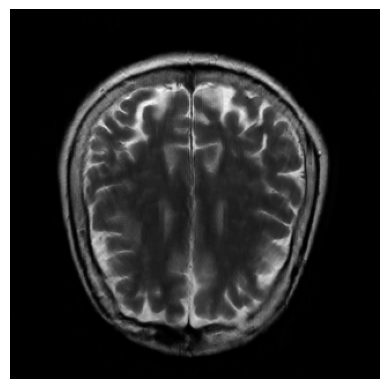

In [71]:
show_image(cartesian_images)

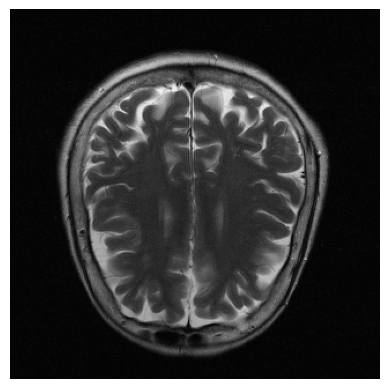

In [72]:
show_image(first_target_brain_fastmri)

In [65]:
psnr(first_target_brain_fastmri.detach().cpu().numpy(), cartesian_images.detach().cpu().numpy())

np.float64(30.244118456889204)

In [67]:
def mask_to_trajectory(mask):
    mask = np.squeeze(mask)
    x_values = [x for x in range(-160, 160)]

    trajectory = []
    for i in range(320):
        if mask[i].item() == True:
            for x in x_values:
                trajectory.append([x, i - 160])
    return torch.tensor(trajectory).reshape(-1, 320, 2)

def perturb_Bimask(Bimask, move_std=10):

    # Bimask: [1, 1, H, 1, 1]
    _, _, H, _, _ = Bimask.shape
    Bimask = Bimask.clone()
    perturbed = Bimask.clone()

    selected_rows = (Bimask[0, 0, :, 0, 0] == 1).nonzero(as_tuple=False).squeeze(-1)
    occupied = set(selected_rows.tolist())  # Rows currently set to 1

    for y in selected_rows.tolist():
        for _ in range(10):  # Try up to 10 times
            eps = torch.randn((1,))
            sample = move_std * eps
            shift = int(round(sample))
            y_new = y + shift
            if 0 <= y_new < H and y_new not in occupied:
                perturbed[0, 0, y, 0, 0] = 0  # Clear old row
                perturbed[0, 0, y_new, 0, 0] = 1  # Set new row
                occupied.remove(y)
                occupied.add(y_new)
                break  # Successful move

    # Compute XOR as noise mask: 1 where changed, 0 where same
    noise_mask = (perturbed != Bimask)

    return noise_mask  # Shape: [1, 1, H, 1, 1]

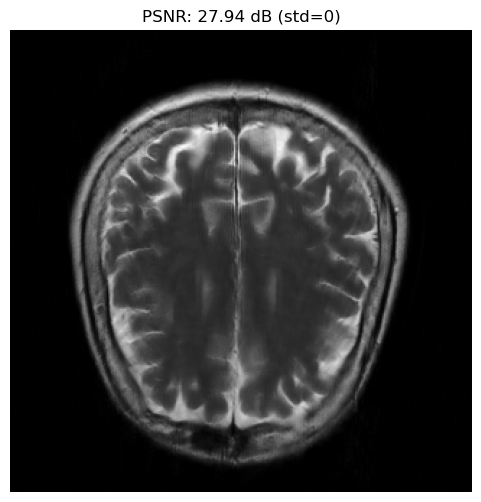

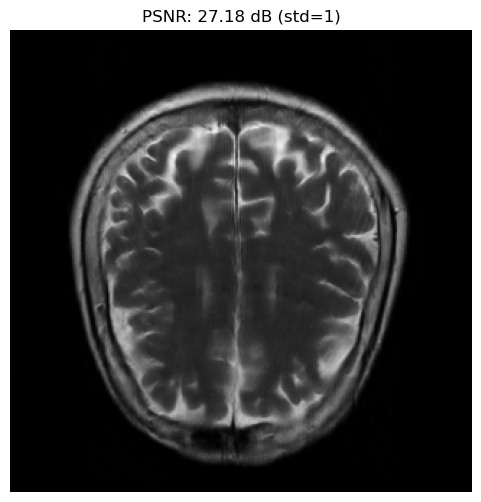

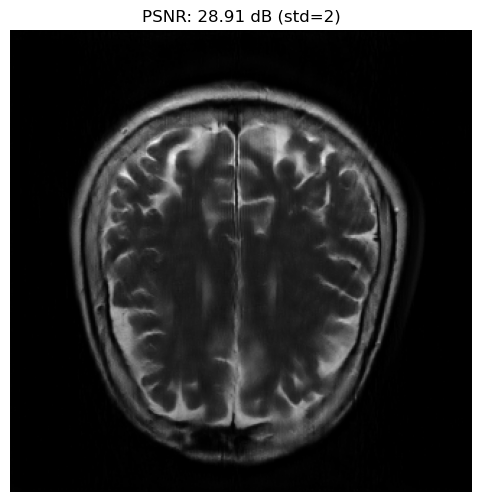

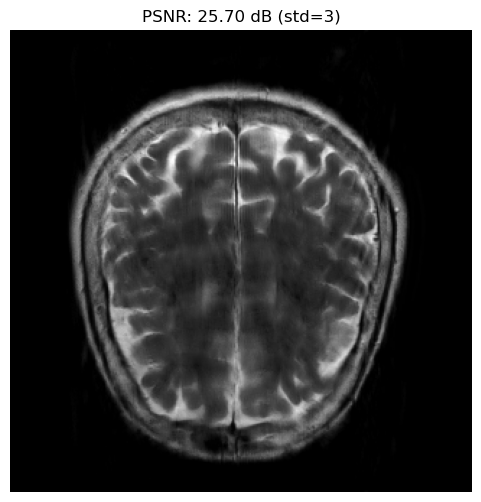

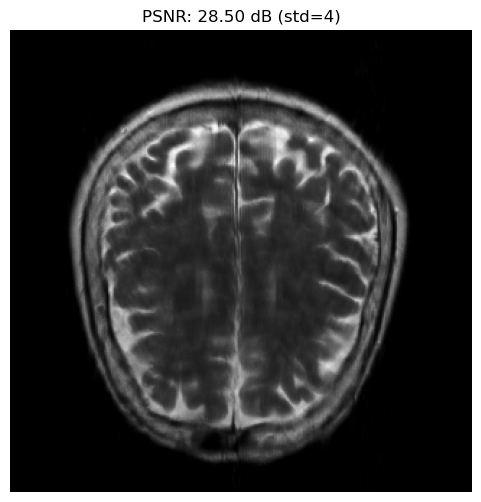

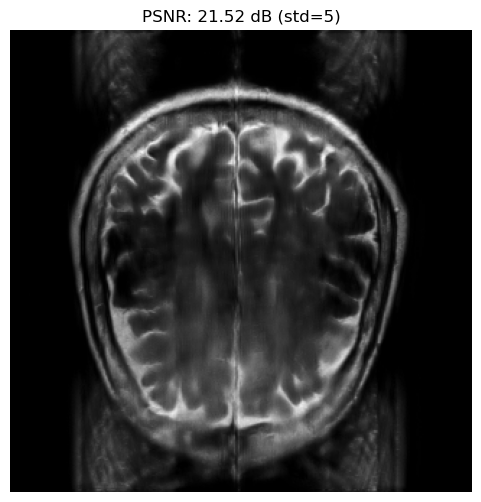

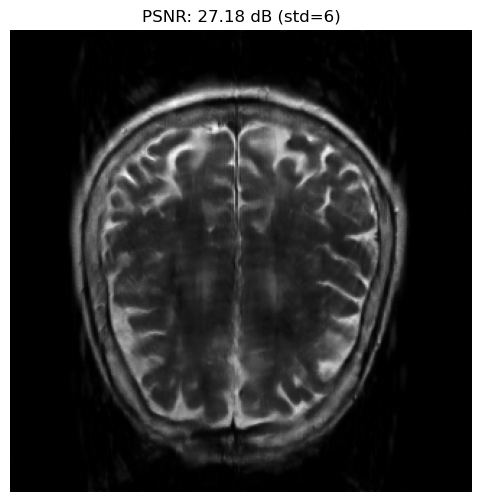

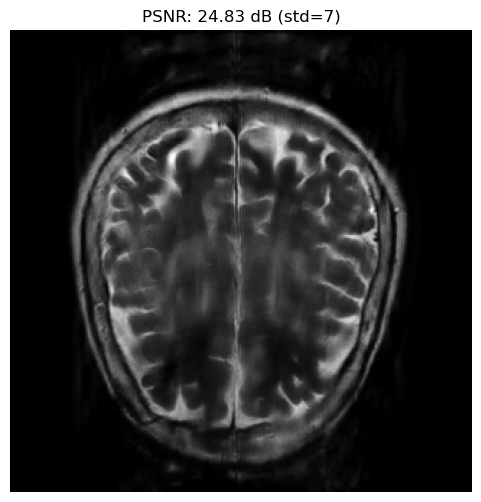

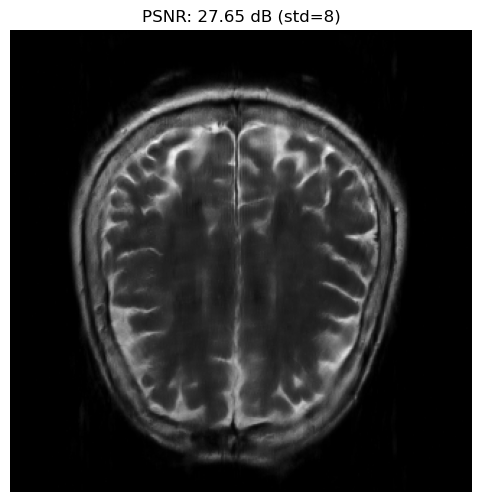

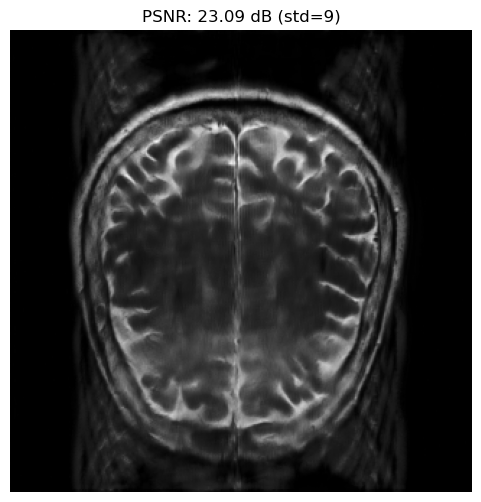

In [74]:
import matplotlib.pyplot as plt
import numpy as np

for std in range(0, 10, 1):
    # Perturb the Bimask
    noise_mask_rand = perturb_Bimask(model_Unet_Cartesian.module.subsampling.Bimask, move_std=std)
    noise_mask_rand = noise_mask_rand.float()
    noise_mask_rand = (
        model_Unet_Cartesian.module.subsampling.Bimask * (1 - noise_mask_rand) +
        (1 - model_Unet_Cartesian.module.subsampling.Bimask) * noise_mask_rand
    )

    # Apply mask
    input_c = fastmri.fft2c(first_input_brain_fastmri).to("cuda")
    input_c_masked = input_c.unsqueeze(0) * noise_mask_rand
    input_c_masked = fastmri.ifft2c(input_c_masked)
    input_c_masked = transforms.complex_abs(input_c_masked)

    # Run through model
    output = model_Unet_Cartesian.module.reconstruction_model(input_c_masked.to("cuda"))

    # Compute PSNR
    output_np = output.squeeze().detach().cpu().numpy()
    target_np = first_target_brain_fastmri.squeeze().detach().cpu().numpy()
    psnr_val = psnr(target_np, output_np)

    # Display image with PSNR
    plt.figure(figsize=(6, 6))
    plt.imshow(output_np, cmap='gray')
    plt.title(f"PSNR: {psnr_val:.2f} dB (std={std})")
    plt.axis('off')
    plt.show()

In [81]:
def generate_adversarial_noise_mask_pgd(model, input, Bimask, target, k=10, steps=10, lr=1.0):
    """
    Generate adversarial noise mask using PGD-style optimization with top-k projection.

    Args:
        model: The model with a `.transform()` method that works on k-space.
        input: [B, 1, H, W, 2] complex-valued input in image domain.
        Bimask: [B, 1, H, 1, 1] base binary sampling mask.
        target: Ground truth image [B, 1, H, W, 2].
        k: Number of row flips allowed.
        steps: Number of PGD steps.
        lr: Step size for gradient update.

    Returns:
        noise_mask: [B, 1, H, 1, 1] binary tensor with exactly k ones per sample.
    """
    assert len(input.shape) == 5
    B, _, H, _, _ = Bimask.shape
    device = input.device

    # Initialize noise scores per row (logits)
    noise_logits = torch.zeros(B, H, device=device, requires_grad=True)

    for _ in range(steps):
        # Forward
        noise_mask_soft = torch.sigmoid(noise_logits)

        # PGD projection: top-k selection per sample
        with torch.no_grad():
            topk_vals, topk_idx = torch.topk(noise_mask_soft, k=k, dim=1)
            projected_noise_mask = torch.zeros_like(noise_mask_soft)
            projected_noise_mask.scatter_(1, topk_idx, 1.0)

        projected_noise_mask.requires_grad = True
        projected_noise_mask_reshaped = projected_noise_mask.view(B, 1, H, 1, 1).to(device)

        # XOR mask
        Bimask_f = Bimask.float().to(device)
        adv_mask = Bimask_f * (1 - projected_noise_mask_reshaped) + (1 - Bimask_f) * projected_noise_mask_reshaped

        # Apply to k-space
        input_c = fastmri.fft2c(input)
        input_c_masked = input_c * adv_mask
        input_c_masked = fastmri.ifft2c(input_c_masked)
        input_c_masked = transforms.complex_abs(input_c_masked)
        output = model.module.reconstruction_model(input_c_masked.to("cuda"))

        # Adversarial loss (maximize error)
        loss = F.mse_loss(output.squeeze().to("cuda"), target.squeeze().to("cuda"))  # negative: maximize error

        # Backward
        loss.backward()
        grad = projected_noise_mask.grad  # [B, H]

        # PGD update: take a gradient step
        with torch.no_grad():
            noise_logits = noise_logits + lr * grad
            noise_logits.requires_grad = True  # re-enable for next loop

    # Final projection (hard binary)
    with torch.no_grad():
        noise_mask = torch.zeros(B, H, device=device)
        topk_vals, topk_idx = torch.topk(torch.sigmoid(noise_logits), k=k, dim=1)
        noise_mask.scatter_(1, topk_idx, 1.0)
        noise_mask = noise_mask.view(B, 1, H, 1, 1)

    return noise_mask

tensor([], size=(0, 5), dtype=torch.int64)


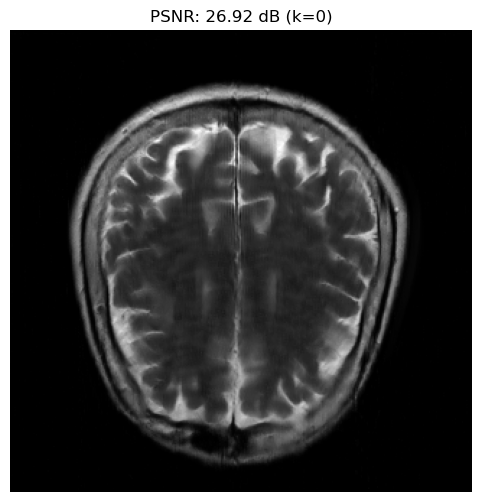

tensor([[  0,   0, 160,   0,   0]])


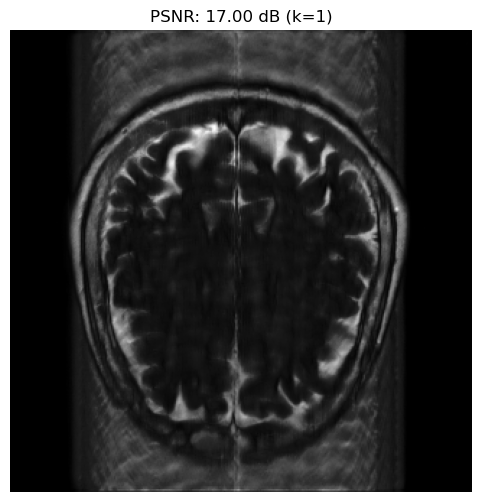

tensor([[  0,   0, 136,   0,   0],
        [  0,   0, 160,   0,   0]])


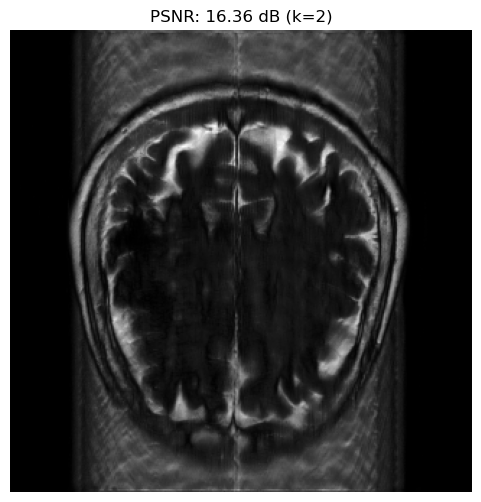

tensor([[  0,   0, 158,   0,   0],
        [  0,   0, 161,   0,   0],
        [  0,   0, 162,   0,   0]])


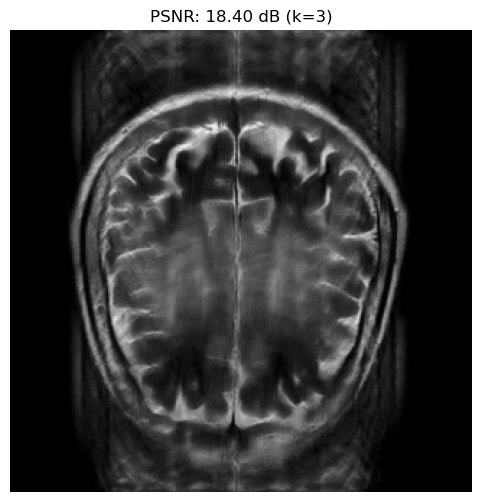

tensor([[  0,   0, 159,   0,   0],
        [  0,   0, 160,   0,   0],
        [  0,   0, 165,   0,   0],
        [  0,   0, 174,   0,   0]])


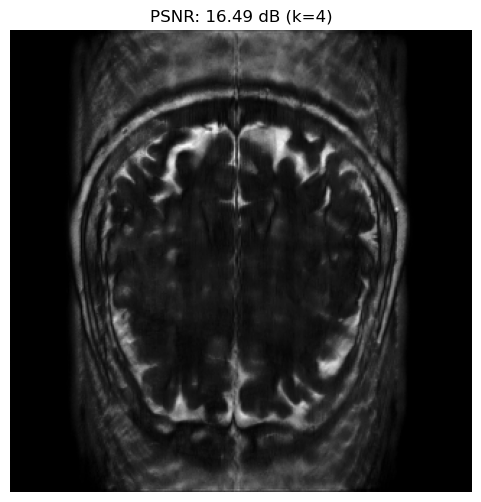

tensor([[  0,   0, 136,   0,   0],
        [  0,   0, 153,   0,   0],
        [  0,   0, 158,   0,   0],
        [  0,   0, 159,   0,   0],
        [  0,   0, 160,   0,   0]])


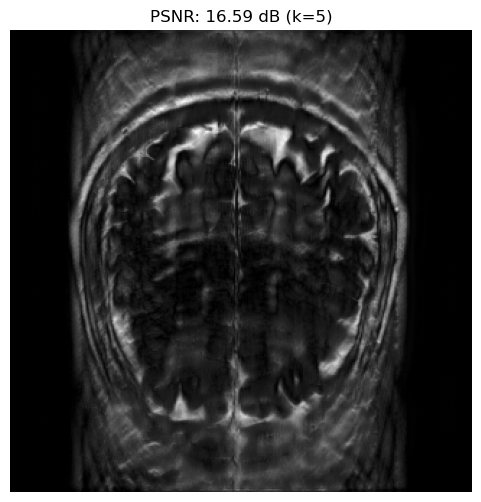

tensor([[  0,   0, 136,   0,   0],
        [  0,   0, 153,   0,   0],
        [  0,   0, 159,   0,   0],
        [  0,   0, 160,   0,   0],
        [  0,   0, 165,   0,   0],
        [  0,   0, 177,   0,   0]])


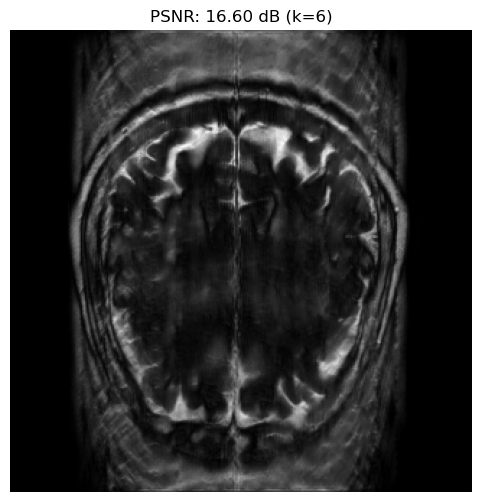

tensor([[  0,   0, 136,   0,   0],
        [  0,   0, 157,   0,   0],
        [  0,   0, 158,   0,   0],
        [  0,   0, 159,   0,   0],
        [  0,   0, 161,   0,   0],
        [  0,   0, 162,   0,   0],
        [  0,   0, 163,   0,   0]])


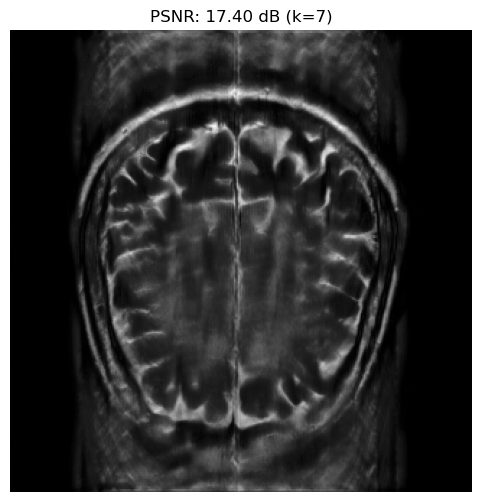

tensor([[  0,   0, 154,   0,   0],
        [  0,   0, 158,   0,   0],
        [  0,   0, 159,   0,   0],
        [  0,   0, 160,   0,   0],
        [  0,   0, 161,   0,   0],
        [  0,   0, 162,   0,   0],
        [  0,   0, 166,   0,   0],
        [  0,   0, 177,   0,   0]])


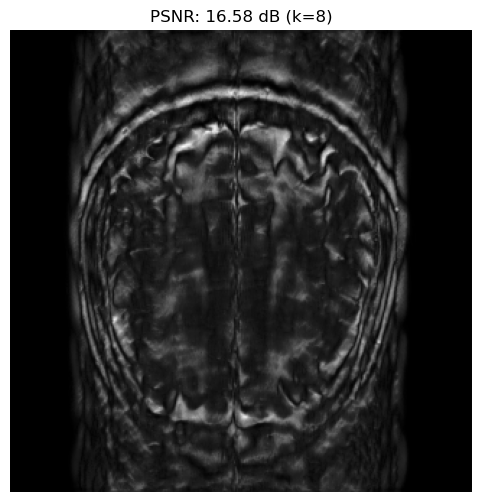

tensor([[  0,   0, 136,   0,   0],
        [  0,   0, 153,   0,   0],
        [  0,   0, 158,   0,   0],
        [  0,   0, 159,   0,   0],
        [  0,   0, 160,   0,   0],
        [  0,   0, 161,   0,   0],
        [  0,   0, 162,   0,   0],
        [  0,   0, 167,   0,   0],
        [  0,   0, 186,   0,   0]])


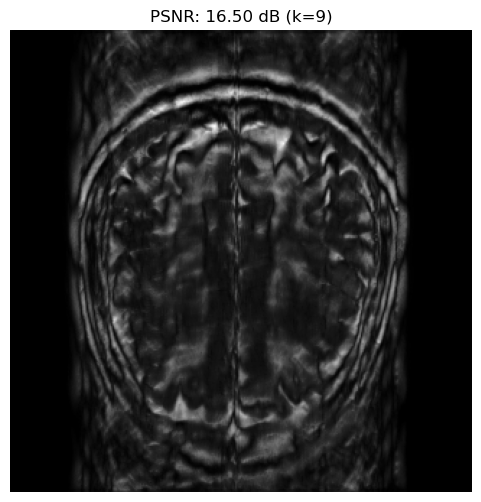

In [87]:
import matplotlib.pyplot as plt
import numpy as np

for k in range(0, 10, 1):
    # Perturb the Bimask
    noise_mask = generate_adversarial_noise_mask_pgd(model_Unet_Cartesian, first_input_brain_fastmri.unsqueeze(0), model_Unet_Cartesian.module.subsampling.Bimask, first_target_brain_fastmri, k=k)
    noise_mask_rand = noise_mask.float().to("cuda")
    noise_mask_rand = (
        model_Unet_Cartesian.module.subsampling.Bimask * (1 - noise_mask_rand) +
        (1 - model_Unet_Cartesian.module.subsampling.Bimask) * noise_mask_rand
    )
    flipped_indices = (noise_mask == 1).nonzero(as_tuple=False)
    print(flipped_indices)
    # Apply mask
    input_c = fastmri.fft2c(first_input_brain_fastmri).to("cuda")
    input_c_masked = input_c.unsqueeze(0) * noise_mask_rand
    input_c_masked = fastmri.ifft2c(input_c_masked)
    input_c_masked = transforms.complex_abs(input_c_masked)

    # Run through model
    output = model_Unet_Cartesian.module.reconstruction_model(input_c_masked.to("cuda"))

    # Compute PSNR
    output_np = output.squeeze().detach().cpu().numpy()
    target_np = first_target_brain_fastmri.squeeze().detach().cpu().numpy()
    psnr_val = psnr(target_np, output_np)

    # Display image with PSNR
    plt.figure(figsize=(6, 6))
    plt.imshow(output_np, cmap='gray')
    plt.title(f"PSNR: {psnr_val:.2f} dB (k={k})")
    plt.axis('off')
    plt.show()

In [108]:
def generate_adversarial_flip_mask_pgd(model, input, Bimask, target, budget=1, steps=10, lr=1.0):
    """
    PGD-style adversarial mask generator with a fixed flip budget (1s to 0s and 0s to 1s).

    Args:
        model: Model with `.reconstruction_model`.
        input: [B, 1, H, W, 2] image-domain complex input.
        Bimask: [B, 1, H, 1, 1] binary mask.
        target: [B, 1, H, W, 2] ground truth image.
        budget: Number of 1→0 and 0→1 swaps.
        steps: PGD steps.
        lr: Learning rate for PGD.

    Returns:
        final_mask: [B, 1, H, 1, 1] mask with `budget` swaps applied.
    """
    assert input.shape[0] == 1, "Only supports batch size 1 for now."
    device = input.device
    B, _, H, _, _ = Bimask.shape

    # Move everything to device
    input = input.to(device)
    Bimask = Bimask.to(device).float()
    target = target.to(device)

    # Flatten base mask
    Bimask_flat = Bimask.view(B, H)

    # Get row indices for 1s and 0s
    with torch.no_grad():
        indices_1 = (Bimask_flat[0] == 1).nonzero(as_tuple=False).squeeze().to(device)
        indices_0 = (Bimask_flat[0] == 0).nonzero(as_tuple=False).squeeze().to(device)

    if indices_0.numel() < budget or indices_1.numel() < budget:
        raise ValueError(f"Not enough 1s or 0s in mask to flip with budget={budget}")

    # Initialize logits for row scores
    logits_on = torch.randn(indices_0.shape[0], device=device, requires_grad=True)
    logits_off = torch.randn(indices_1.shape[0], device=device, requires_grad=True)

    optimizer = torch.optim.SGD([logits_on, logits_off], lr=lr)

    for _ in range(steps):
        optimizer.zero_grad()

        soft_on = torch.softmax(logits_on, dim=0)  # shape: [#0s]
        soft_off = torch.softmax(logits_off, dim=0)  # shape: [#1s]

        # Build soft mask from softmax distributions
        flip_on_mask = torch.zeros(H, device=device)
        flip_off_mask = torch.zeros(H, device=device)
        flip_on_mask[indices_0] = soft_on
        flip_off_mask[indices_1] = soft_off

        adv_mask_soft = Bimask_flat[0] - flip_off_mask + flip_on_mask
        adv_mask_soft = adv_mask_soft.clamp(0, 1).view(1, 1, H, 1, 1).to(device)

        # Apply mask in frequency domain
        input_c = fastmri.fft2c(input).to(device)
        input_c_masked = input_c * adv_mask_soft
        input_c_masked = fastmri.ifft2c(input_c_masked)
        input_c_masked = transforms.complex_abs(input_c_masked)

        output = model.module.reconstruction_model(input_c_masked.to("cuda"))

        # Adversarial objective: maximize error
        loss = F.mse_loss(output.squeeze().to("cuda"), target.squeeze().to("cuda"))
        (-loss).backward()  # gradient ascent

        optimizer.step()

    # Final hard selection after PGD steps
    with torch.no_grad():
        top_on = indices_0[torch.topk(logits_on, k=budget).indices]
        top_off = indices_1[torch.topk(logits_off, k=budget).indices]

        final_mask = Bimask_flat.clone()
        final_mask[0, top_off] = 0.0
        final_mask[0, top_on] = 1.0

        return final_mask.view(B, 1, H, 1, 1).to(device)


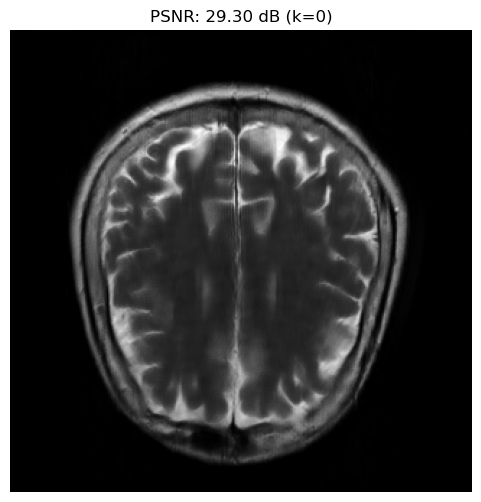

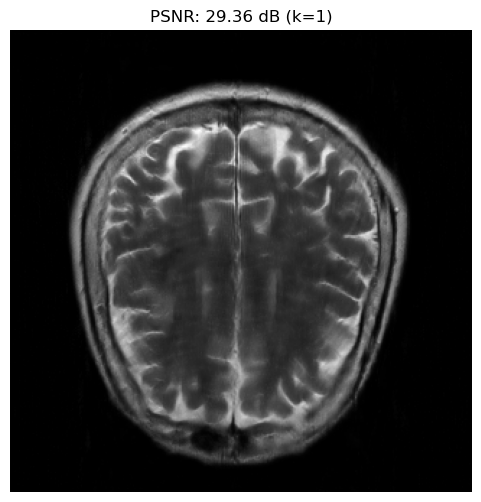

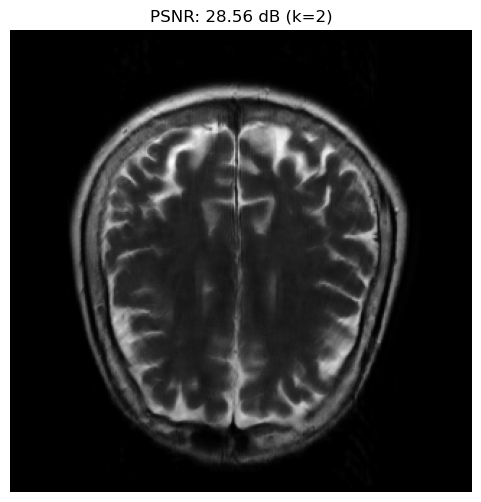

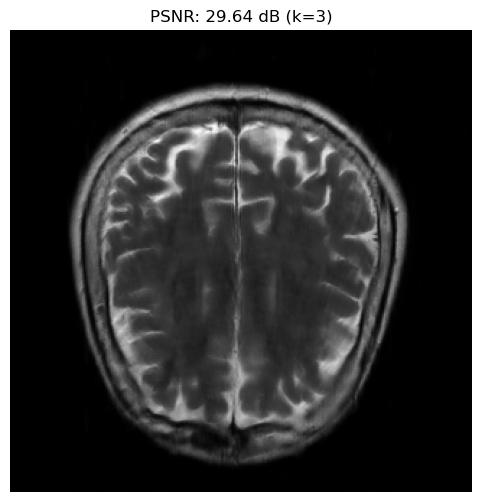

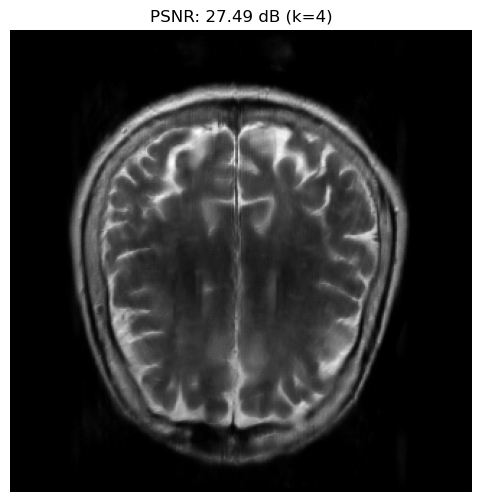

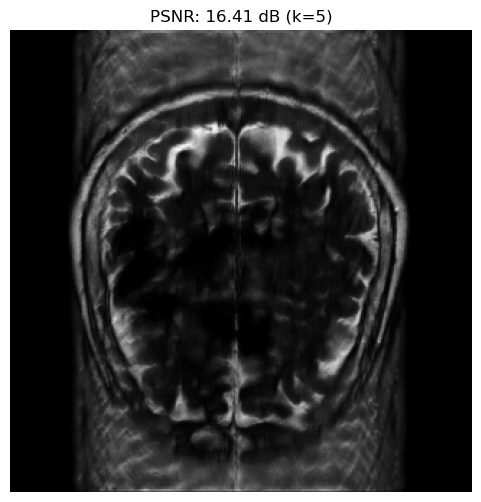

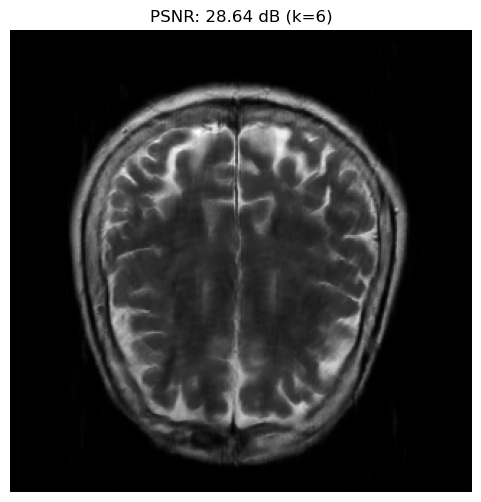

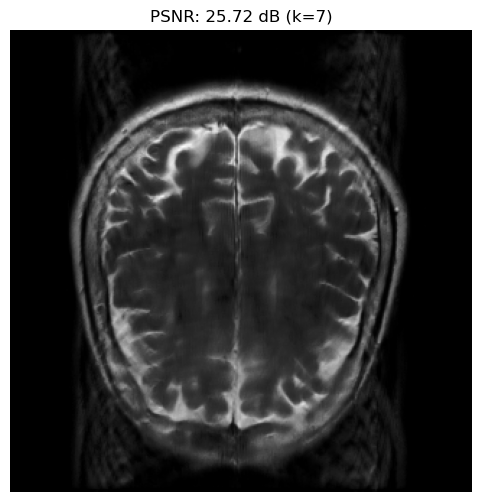

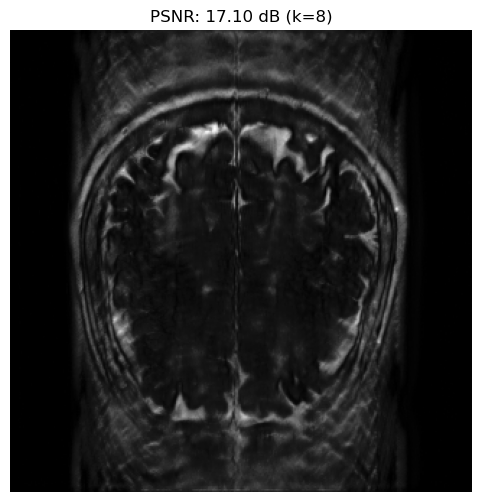

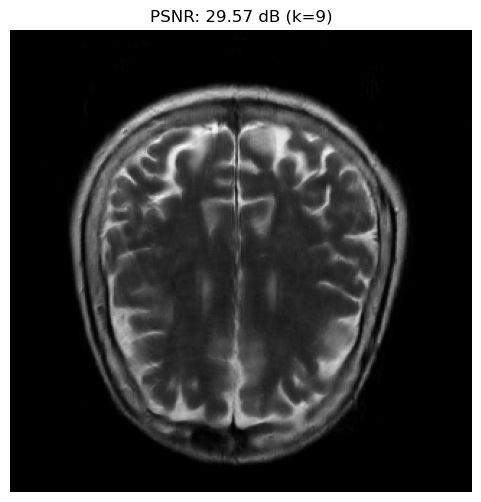

In [113]:
import matplotlib.pyplot as plt
import numpy as np

for k in range(0, 10, 1):
    # Perturb the Bimask
    noise_mask = generate_adversarial_flip_mask_pgd(model_Unet_Cartesian, first_input_brain_fastmri.unsqueeze(0), model_Unet_Cartesian.module.subsampling.Bimask, first_target_brain_fastmri, budget=k).to("cuda")
    flipped_indices = (noise_mask == 1).nonzero(as_tuple=False)
    # Apply mask
    input_c = fastmri.fft2c(first_input_brain_fastmri).to("cuda")
    input_c_masked = input_c.unsqueeze(0) * noise_mask
    input_c_masked = fastmri.ifft2c(input_c_masked)
    input_c_masked = transforms.complex_abs(input_c_masked)

    # Run through model
    output = model_Unet_Cartesian.module.reconstruction_model(input_c_masked.to("cuda"))

    # Compute PSNR
    output_np = output.squeeze().detach().cpu().numpy()
    target_np = first_target_brain_fastmri.squeeze().detach().cpu().numpy()
    psnr_val = psnr(target_np, output_np)

    # Display image with PSNR
    plt.figure(figsize=(6, 6))
    plt.imshow(output_np, cmap='gray')
    plt.title(f"PSNR: {psnr_val:.2f} dB (k={k})")
    plt.axis('off')
    plt.show()